<a href="https://colab.research.google.com/github/jjschueder/7331DataMiningNotebooks/blob/master/lab2/Lab2_DC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Data Mining 7331 - Spring 2020**

## Lab 2 - Classification

#### Daniel Clark, Joe Schueder, Jeff Washburn, Armando Vela


### Introduction

The Iowa Liquor Sales dataset is an API from Google’s Bigquery which contains the wholesale purchases by retail stores in the Iowa area. The dataset includes the spirit purchase details by product, date of purchase, and location the item was purchased from an Iowa Class “E” liquor license holder (retail stores). The time frame of this data starts from January 1, 2012 through December 31, 2019. As part of the study commissioned by the Iowa Department of Commerce, all alcoholic sales within the state were logged into the Department system, and in turn, published as open data by the State of Iowa. The dataset contains detail on the name, product, quantity and location of the individual container or package sale between the wholesaler (vendor) and the retailer.

### Data Description

The initial data set was 4.63GB with 17.7 million rows. We subsetted that down to 400k rows using a random set of data from the 2019 sales data. This work was done in our initial processing from earlier.

So taking our initial processing that was done from previous work, we further refined the 400k dataset by one-hot encoding the categorical features for sales month, liquor categories, and the stores. The stores will not be used in this analysis; however, it was still one-hot encoded for future analysis

It's also worth noting, that we used the log transformed values for sales dollars, cost per liter, state bottle cost and volume sold in liters along with the liquor catogory to focus on our classification and ensure that outliers do not hold too heavy of a weight in our analysis. 


In [2]:
import pandas as pd

url_dataset = 'https://raw.githubusercontent.com/jjschueder/7331DataMiningNotebooks/master/Live%20Assignments/df1hotmerge2.csv'
data = pd.read_csv(url_dataset, nrows = 40000)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 68 columns):
Unnamed: 0                  40000 non-null int64
pack                        40000 non-null int64
bottle_volume_ml            40000 non-null int64
state_bottle_cost           40000 non-null float64
state_bottle_retail         40000 non-null float64
bottles_sold                40000 non-null int64
sale_dollars                40000 non-null float64
volume_sold_liters          40000 non-null float64
volume_sold_gallons         40000 non-null float64
counter                     40000 non-null int64
liquor_category             40000 non-null object
store_parent                40000 non-null object
month                       40000 non-null object
year                        40000 non-null int64
monthyear                   40000 non-null object
liquor_category_AMARETTO    40000 non-null int64
liquor_category_BRANDY      40000 non-null int64
liquor_category_GIN         40000 non-null i

Here you can see that we have 400,000 non null objects one-hot encoded to include month, year, store name and alcohol type. For our previous classification analysis, we dropped the liquor category and all the liquor types and just used the binary classification for Whiskey and Non-Whiskey. With 1 representing whether the liquor type was whiskey and 0 representing a non whiskey. 

### Project Requirements

####Data Preparation (15 points total)

• Define and prepare your class variables. Use proper variable
representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for
dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for
the analysis.

• Describe the final dataset that is used for classification/regression (include a
description of any newly formed variables you created)

####Modeling and Evaluation (70 points total)

• Choose and explain your evaluation metrics that you will use (i.e., accuracy,
precision, recall, F-measure, or any metric we have discussed). Why are the measure(s)
appropriate for analyzing the results of your modeling? Give a detailed explanation
backing up any assertions.

• Choose the method you will use for dividing your data into training and
testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why
your chosen method is appropriate or use more than one method as appropriate.

• Create three different classification/regression models (e.g., random forest,
KNN, and SVM). Two modeling techniques must be new (but the third could be SVM or
logistic regression). Adjust parameters as appropriate to increase generalization
performance using your chosen metric.

• Analyze the results using your chosen method of evaluation. Use
visualizations of the results to bolster the analysis. Explain any visuals and analyze why
they are interesting to someone that might use this model.

• Discuss the advantages of each model for each classification task, if any. If
there are not advantages, explain why. Is any model better than another? Is the
difference significant with 95% confidence? Use proper statistical comparison methods.

• Which attributes from your analysis are most important? Use proper
methods discussed in class to evaluate the importance of different attributes. Discuss
the results and hypothesize about why certain attributes are more important than others
for a given classification task.


####Deployment 

• How useful is your model for interested parties (i.e., the companies or
organizations that might want to use it for prediction)? How would you measure the
model's value if it was used by these parties? How would your deploy your model for
interested parties? What other data should be collected? How often would the model
need to be updated, etc.? 


####Exceptional Work 
• You have free reign to provide additional modeling.

• One idea: grid search parameters in a parallelized fashion and visualize the
performances across attributes. Which parameters are most significant for making a
good model for each classification algorithm?

## Data Preparation Part 1

We obtained a dataset on Iowa Liquor Sales from Google Bigquery. The aim of recording the data set is for the state to track alcohol and liquor sales from wholesalers and retailers from the year 2012 through 2019. You can see some Exploratory Data Analysis of this dataset below: 

https://github.com/jjschueder/7331DataMiningNotebooks/blob/master/lab1/msds7331_clark_schueder_vela_washburn.ipynb



In [3]:
# Import all necessary libraries we will be using in our dataset

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
import sklearn
import statistics
import random

from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile, RFE, SelectFromModel

from sklearn.preprocessing import StandardScaler, Binarizer

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, auc, roc_curve
from IPython.display import display, HTML

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, TimeSeriesSplit, StratifiedShuffleSplit

from sklearn.naive_bayes import MultinomialNB

from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor,AdaBoostClassifier,RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

matplotlib.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

print(data.shape)
data.head()

(40000, 68)


,Unnamed: 0,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,counter,liquor_category,store_parent,month,year,monthyear,liquor_category_AMARETTO,liquor_category_BRANDY,liquor_category_GIN,liquor_category_LIQUEUR,liquor_category_Other,liquor_category_RUM,liquor_category_SCHNAPPS,liquor_category_TEQUILA,liquor_category_VODKA,liquor_category_WHISKY,store_parent_CVS,store_parent_Caseys,store_parent_Hy-Vee,store_parent_Kum&Go,store_parent_Other,store_parent_QuikTrip,store_parent_SamsClub,store_parent_SmokingJoes,store_parent_Target,store_parent_Wal-Mart,store_parent_Walgreens,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep,year_2019,monthyear_Apr-2019,monthyear_Aug-2019,monthyear_Dec-2019,monthyear_Feb-2019,monthyear_Jan-2019,monthyear_Jul-2019,monthyear_Jun-2019,monthyear_Mar-2019,monthyear_May-2019,monthyear_Nov-2019,monthyear_Oct-2019,monthyear_Sep-2019,sale_dollars_trans,cost_per_liter,cost_per_liter_trans,state_bottle_cost_trans,bottles_sold_trans,volume_sold_liters_trans,grossmargin
0,0,20,375,3.85,5.78,20,115.60,7.50,1.98,1,Other,Other,Nov,2019,Nov-19,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,4.750136,15.413333,2.735233,1.348073,2.995732,2.014903,0.333910
1,1,8,50,8.75,13.13,1,13.13,0.05,0.01,1,Other,Other,Nov,2019,Nov-19,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,2.574900,262.600000,5.570632,2.169054,0.000000,-2.995732,0.333587
2,2,12,1000,16.50,24.75,6,148.50,6.00,1.58,1,GIN,Hy-Vee,May,2019,May-19,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,5.000585,24.750000,3.208825,2.803360,1.791759,1.791759,0.333333
3,3,6,750,21.17,31.76,24,762.24,18.00,4.75,1,WHISKY,Hy-Vee,Nov,2019,Nov-19,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,6.636261,42.346667,3.745890,3.052585,3.178054,2.890372,0.333438
4,4,6,1750,9.31,13.97,12,167.64,21.00,5.54,1,Other,Hy-Vee,Nov,2019,Nov-19,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,5.121819,7.982857,2.077296,2.231089,2.484907,3.044522,0.333572


**Our data Preparation includes the folloiwng layout**

*   Since we are predicting our liquor category type (opening to the entire list of categories and not just one), we can assign them a numerical value.
* Create new variables using aggredate data on profit, total cost and revenue
*   Since we transformed a number of continuous variables, we can drop them so that we are working directly on our normalized data




In [4]:
# Since we are predicting our liquor category type (opening to the entire list of categories and not just one), we can assign them a numerical value.

print (data['liquor_category'].unique())

df = pd.DataFrame({'col_1':[133,255,36,477,55,63]})
d = {'1':'M', '2': 'C', '3':'a', '4':'f', '5':'r', '6':'s'}
def ifef(col):
    col = str(col)
    return d[col[0]]

df['id_label'] = df['col_1'].apply(ifef)
print(df)

d = {'O':'1', 'G': '2', 'W':'3', 'T':'4', 'L':'5', 'V':'6', 'R':'7', 'S': '8', 'A':'9', 'B':'10'}

#data['id_label'] = data['liquor_category'].apply(ifef)

data['id_label'] = data['liquor_category'].astype(str).str[0].map(d)

print(data.head())

['Other' 'GIN' 'WHISKY' 'TEQUILA' 'LIQUEUR' 'VODKA' 'RUM' 'SCHNAPPS'
 'AMARETTO' 'BRANDY']
   col_1 id_label
0    133        M
1    255        C
2     36        a
3    477        f
4     55        r
5     63        s
   Unnamed: 0  pack  ...  grossmargin  id_label
0           0    20  ...     0.333910         1
1           1     8  ...     0.333587         1
2           2    12  ...     0.333333         2
3           3     6  ...     0.333438         3
4           4     6  ...     0.333572         1

[5 rows x 69 columns]


In [0]:
# Create new variables using aggredate data on profit, total cost and revenue

#do some calculations for cost and profit
data['profit'] = data['state_bottle_retail']*data['bottles_sold'] - data['state_bottle_cost']* data['bottles_sold']
data['profit_trans']= np.log(data['profit'])

data['totalcost'] = data['state_bottle_cost']* data['bottles_sold']
data['totalcost_trans']= np.log(data['totalcost'])

data['revenue'] = data['state_bottle_retail']*data['bottles_sold']
data['revenue_trans']= np.log(data['revenue'])

data['bottle_volume_ml_trans']= np.log(data['bottle_volume_ml'])


(40000, 12)


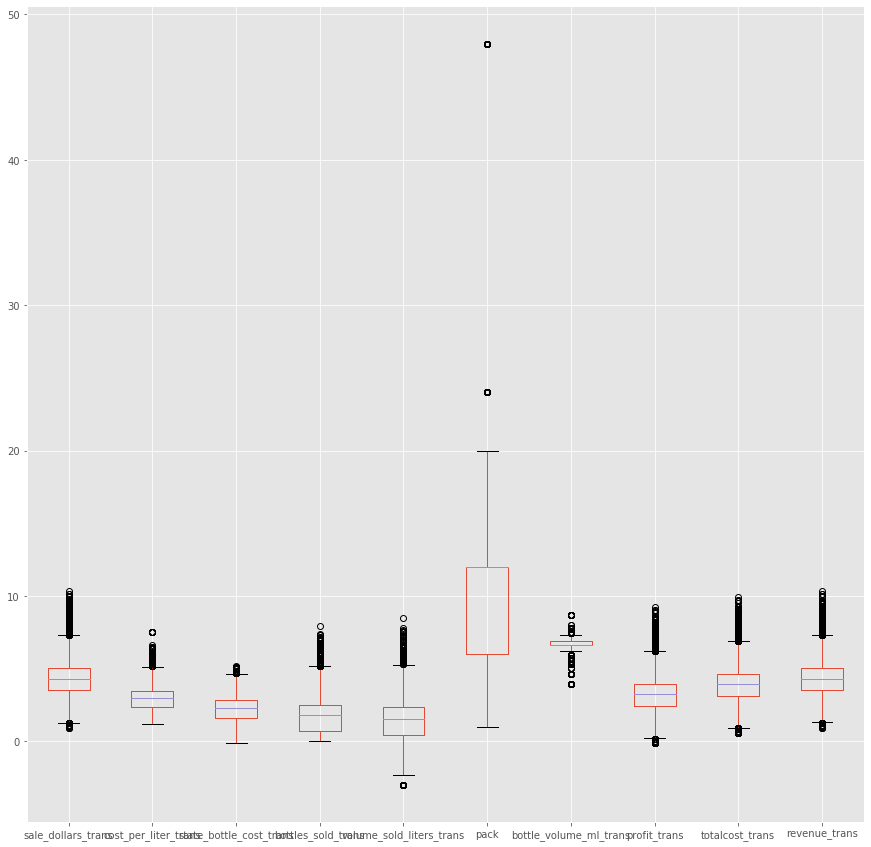

In [6]:
# Since we transformed a number of continuous variables, we can drop them so that we are working directly on our normalized data


# Remove unwanted columns, which include all the specific liquor categories, 
# except for liquor_category_WHISKY since that is what we want to classify on, along
# with all the store_ attributes
"""
cat_vars=['counter', 'liquor_category', 'store_parent',
 'month', 'year', 'monthyear', 'liquor_category_AMARETTO', 'liquor_category_BRANDY', 'liquor_category_GIN', 
 'liquor_category_LIQUEUR', 'liquor_category_Other', 'liquor_category_RUM', 'liquor_category_SCHNAPPS', 
 'liquor_category_TEQUILA', 'liquor_category_VODKA', 'month_Apr', 'month_Aug', 'month_Dec', 'month_Feb',
 'month_Jan', 'month_Jul', 'month_Jun', 'month_Mar', 'month_May', 'month_Nov', 'month_Oct', 'month_Sep', 
 'store_parent_CVS', 'store_parent_Caseys', 'store_parent_Hy-Vee', 'store_parent_Kum&Go', 
 'store_parent_Other', 'store_parent_QuikTrip', 'store_parent_SamsClub', 'store_parent_SmokingJoes', 
 'store_parent_Target', 'store_parent_Wal-Mart', 'store_parent_Walgreens']
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
"""
#keep our transformed detail, along with the timing and store name detail

to_keep=['sale_dollars_trans', 'cost_per_liter_trans', 'store_parent',
      'state_bottle_cost_trans', 'bottles_sold_trans',
       'volume_sold_liters_trans','pack', 'bottle_volume_ml_trans', 
       'profit_trans', 'totalcost_trans', 'revenue_trans', 'id_label']
data_final=data[to_keep]
data_final.columns.values

#boxplot of all the variables
plt.figure(figsize=(15, 15))
ax = data_final.boxplot()
#ax.set_yscale('log')

print(data_final.shape)


From the standpoint of the boxplots, we can see that we have some uniformity in our continuous features with minimal outliers. To help us accurately predict our liquor categires, this will be helpful in us using these features build versious models to compare performance. Running a quick shape feature, we can see that we are not missing any data.

In [7]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 12 columns):
sale_dollars_trans          40000 non-null float64
cost_per_liter_trans        40000 non-null float64
store_parent                40000 non-null object
state_bottle_cost_trans     40000 non-null float64
bottles_sold_trans          40000 non-null float64
volume_sold_liters_trans    40000 non-null float64
pack                        40000 non-null int64
bottle_volume_ml_trans      40000 non-null float64
profit_trans                40000 non-null float64
totalcost_trans             40000 non-null float64
revenue_trans               40000 non-null float64
id_label                    40000 non-null object
dtypes: float64(9), int64(1), object(2)
memory usage: 3.7+ MB


Running a quick df describe, we can se that almost all of our variables are floats to account for the transformations. With the id_label and store parent being an object features used as our classifiers we are looking to use in our datasets. The last feature pack is represented as an int, which makes sense because they are typically sold in packs of 6, 12, 24 and 48.

## Data Preparation Part 2

To describe our final dataset 

In [9]:
data_final.describe()

,sale_dollars_trans,cost_per_liter_trans,state_bottle_cost_trans,bottles_sold_trans,volume_sold_liters_trans,pack,bottle_volume_ml_trans,profit_trans,totalcost_trans,revenue_trans
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,4.298454,2.971822,2.235238,1.657888,1.326632,12.127775,6.576622,3.200717,3.893126,4.298837
std,1.127726,0.865337,0.782898,1.106078,1.384640,8.718976,0.762413,1.127691,1.127849,1.127796
min,0.943906,1.163151,-0.116534,0.000000,-2.995732,1.000000,3.912023,-0.150823,0.536493,0.943906
25%,3.544432,2.345645,1.607436,0.693147,0.405465,6.000000,6.620073,2.446685,3.138966,3.544432
50%,4.319087,2.987700,2.306577,1.791759,1.504077,12.000000,6.620073,3.222071,3.912823,4.319087
75%,5.050625,3.465319,2.839078,2.484907,2.351375,12.000000,6.907755,3.943522,4.634341,5.040582
max,10.352874,7.495542,5.164729,7.901007,8.460623,48.000000,8.699515,9.254262,9.947409,10.352874


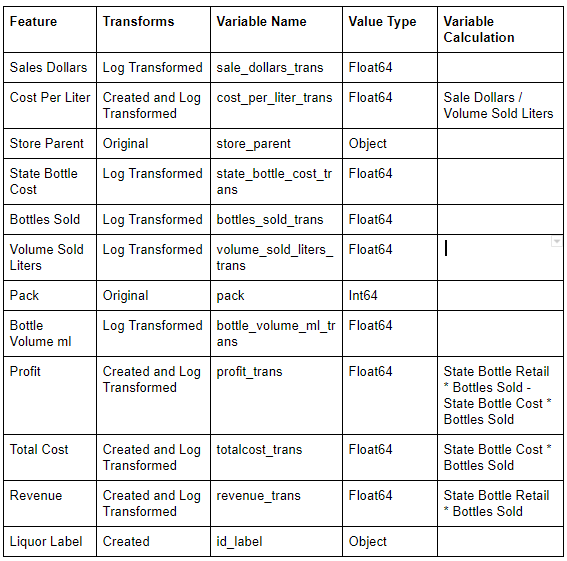


In [10]:
data_final.shape

(40000, 12)

Our final data set includes 12 features and 400,000 entries. 

##Modeling and Evaluation 1

The purpose of this Model is to build a classifier of the alcohol category and detirmine the sales and item measures that play the most weight into predicting the correct alcohol category. 

An ROC curve, also known as a Reciever Operation Characteristic Curve is a plot that calculates and can be used to compare the classifiers we will use in our modeling along with the true positive rate (TPR) and false positive rate (FPR) they convey. From a topline level, you can use the Area Under the Curve (AUC) to help detirmine which can better pair an observation with the correct liquor cateogry. An AUC score of 1.0 denotes a perfect classifier and an area of 0.5 represents a model is no better than a random guess.

In addition to the ROC-AUC value we will use to evaluate classifiers, we will be using other evaluators as well. 

**Accuracy** - Accuracy is the total number of correct predictions over the total number of predictions made. Accuracy will be plotted in our AUC curve and, while not perfect, is a good singlular measure to evaluate a model. Just be careful that we aren't overclassifying unbalalnced variables. 

Accuracy = (TP + TN)/(TP + FP + FN + TN)

**Precision** - Precision is the Proportions of true positives over the total number of positive outcomes whether accurately predicted or inaccurately predicted. 

Precision = (TP) / (TP + FP)

**Recall** - Also known as sensitivity, recall is the proportion of positive outcomes that were correctly classified by our model. Essentially it tells us how many values we incorrectly predicted while the precision can tell us more about what we correctly classified. 

Recall/Sensitivity = (TP) / (TP + FN)

The aim of our modeling is to focus on maximizing our precision, recall, and accuracy scores in our models



## Modeling and Evaluation 2

So we can begin to set a baseline for our accuracy score, let's do a quick look at the value counts and it's percent distribution of our liquor categories, the ones we are looking to classify. 

In [11]:
#cardio percentage split
(data_final['id_label'].value_counts()/len(data_final))*100

6     32.7700
3     22.6125
7     13.7875
5     13.4000
4      7.1325
1      5.9650
2      4.2900
9      0.0300
10     0.0075
8      0.0050
Name: id_label, dtype: float64

In [12]:
(data['liquor_category'].value_counts()/len(data))*100

VODKA       32.7700
WHISKY      22.6125
RUM         13.7875
LIQUEUR     13.4000
TEQUILA      7.1325
Other        5.9650
GIN          4.2900
AMARETTO     0.0300
BRANDY       0.0075
SCHNAPPS     0.0050
Name: liquor_category, dtype: float64

In [13]:
data_final['id_label'].value_counts()

6     13108
3      9045
7      5515
5      5360
4      2853
1      2386
2      1716
9        12
10        3
8         2
Name: id_label, dtype: int64

In [15]:
data_final = data_final[data_final['id_label'] < "8"]
data_final = data_final[data_final['id_label'] != "10"]
data_final['id_label'].value_counts()

6    13108
3     9045
7     5515
5     5360
4     2853
1     2386
2     1716
Name: id_label, dtype: int64

So that our model is able to run correctly without having to create a large amount of additional variables, we decided to drop the Amaretto, Schnapps and Brandy values since collectively, those represent 17 observations. 

In [16]:
(data_final['store_parent'].value_counts()/len(data_final))*100

Other          46.669835
Hy-Vee         39.106620
Wal-Mart        4.349348
Caseys          2.378511
SamsClub        1.970838
SmokingJoes     1.528149
Kum&Go          1.273041
QuikTrip        1.258035
Target          0.825351
Walgreens       0.417678
CVS             0.222595
Name: store_parent, dtype: float64

In [17]:
data_final.shape

(39983, 12)

Looking at the distribution of liquors in our data_final dataset, we can see that vodka takes up 38% of the liquor sales in our set, followed by Run at 24%, Liquer at 12%, Whisky at 10% and so on. When we run our classifier, we will need to be careful to account for the unbalanced nature of our classifiers to help ensure we aren't overclassifying the majority labels. 

For our data training, we will need to employ synthetic minority oversampling technique (SMOTE), which is designed to subset our data from the minority classes as an example with new synthetic instances similar to these minorities are created and added to a new data set which we will use as a train to our classification models. 

## Classification 1 (Liquor Type)

### Modeling and Evaluation 3



In [0]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10)

def EvaluateClassifierEstimator(classifierEstimator, X, Y, cv):



#Perform cross validation 
    scores = cross_validate(classifierEstimator, X, Y,
                            scoring=['accuracy', 'precision','recall'], 
                            cv=cv, return_train_score=True, 
                            )

    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()
    Rreavg = scores['test_recall'].mean()

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"
    print_str3 = "The average Recall for all cv folds is: \t\t\t {Rreavg:.5}"

    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print(print_str3.format(Rreavg=Rreavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']
    scoresResults['Recall'] = scores['test_recall']
    print(scoresResults)
    return scoresResults

def EvaluateClassifierEstimator2(classifierEstimator, X, Y, cv):
    
  #Perform cross validation 
  from sklearn.model_selection import cross_val_predict
  predictions = cross_val_predict(classifierEstimator, 
                                  X, Y, cv=cv)
    
#model evaluation 
  from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#pass true test set values and predictions to classification_report
  classReport = classification_report(Y,predictions)
  confMat = confusion_matrix(Y,predictions)
  acc = accuracy_score(Y,predictions)
    
  print(classReport)
  print(confMat)
  print(acc)
    
def EvaluateClassifierEstimator3(classifierEstimator, X, Y, cv):
  from sklearn import metrics as mt
  for fold, (train_index, test_index) in enumerate(cv.split(X,Y)):
     X_train = X[train_index]    
     y_train = Y[train_index]  # Based on your code, you might need a ravel call here, but I would look into how you're generating your y
     X_test = X[test_index]
     y_test = Y[test_index]  # See comment on ravel and  y_train
     sm = SMOTE(random_state=101)
     X_train_oversampled, y_train_oversampled = sm.fit_sample(X_train, y_train)
     classifierEstimator.fit(X_train, y_train) 
     y_pred = classifierEstimator.predict(X_test)
     acc = mt.accuracy_score(y_test,y_pred)
     conf = mt.confusion_matrix(y_test,y_pred)
     print("====Iteration",fold," ====")
     print("accuracy", acc )
     print("confusion matrix\n",conf)


Now that we built our cross validation, we can go ahead and start assinging our X's and Ys that we will classify.

In [29]:
%%time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics as mt

features = ['sale_dollars_trans', 'cost_per_liter_trans', 
       'state_bottle_cost_trans', 'bottles_sold_trans',
       'volume_sold_liters_trans', 'pack', 'bottle_volume_ml_trans',
       'profit_trans', 'totalcost_trans', 'revenue_trans']

X2 = data_final[features].copy()

scaler = StandardScaler()
scaler.fit(X2)

#This makes our model's coefficients take on the same scale for accurate feature importance analysis
#Notice we scaled the data before the cross validation
X = scaler.transform(X2)

Y= data_final[['id_label']].copy()
Y2 = Y.values

CPU times: user 32.3 ms, sys: 3.62 ms, total: 36 ms
Wall time: 38.9 ms


In [28]:
X

array([[ 0.40059766, -0.27331513, -1.13290409, ...,  0.40136648,
         0.39966524,  0.40023281],
       [-1.52798177,  3.0029126 , -0.08440289, ..., -1.52813006,
        -1.5282738 , -1.52822628],
       [ 0.62264747,  0.2739084 ,  0.72569099, ...,  0.6218905 ,
         0.62245798,  0.62226876],
       ...,
       [-1.19383675,  2.16897105, -1.00666483, ..., -1.19326113,
        -1.19452269, -1.19410211],
       [ 0.43371756, -0.04688765, -1.68434759, ...,  0.43295476,
         0.43354872,  0.43335064],
       [ 2.07674914,  2.16897105, -1.00666483, ...,  2.07742563,
         2.07570565,  2.0762797 ]])

### Evaluation Model: SMOTE and CV

In [0]:
from sklearn import metrics as mt

# train and test split before resampling
X1_train, X1_test, y1_train, y1_test = train_test_split(X, Y, test_size = 0.2, random_state = 101) 


In [32]:

print("Before OverSampling, counts of label 'Other': {}".format(sum(y1_train['id_label'] == "1")))
print("Before OverSampling, counts of label 'GIN': {} \n".format(sum(y1_train['id_label'] == "2"))) 
print("Before OverSampling, counts of label 'WHISKY': {} \n".format(sum(y1_train['id_label'] == "3"))) 
print("Before OverSampling, counts of label 'TEQUILA': {}".format(sum(y1_train['id_label'] == "4")))
print("Before OverSampling, counts of label 'LIQUEUR': {} \n".format(sum(y1_train['id_label'] == "5"))) 
print("Before OverSampling, counts of label 'VODKA': {} \n".format(sum(y1_train['id_label'] == "6"))) 
print("Before OverSampling, counts of label 'RUM': {} \n".format(sum(y1_train['id_label'] == "7"))) 


# import SMOTE module from imblearn library 
# pip install imblearn (if you don't have imblearn in your system) 
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 2) 
X1_train_res, y1_train_res = sm.fit_sample(X1_train, y1_train.values.ravel()) 
  
print('After OverSampling, the shape of train_X: {}'.format(X1_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y1_train_res.shape)) 
  
print("After OverSampling, counts of label 'Other': {}".format(sum(y1_train_res == "1"))) 
print("After OverSampling, counts of label 'GIN': {}".format(sum(y1_train_res == "2"))) 
print("After OverSampling, counts of label 'WHISKY': {}".format(sum(y1_train_res == "3"))) 
print("After OverSampling, counts of label 'TEQUILA': {}".format(sum(y1_train_res == "4"))) 
print("After OverSampling, counts of label 'LIQUEUR': {}".format(sum(y1_train_res == "5"))) 
print("After OverSampling, counts of label 'VODKA': {}".format(sum(y1_train_res == "6"))) 
print("After OverSampling, counts of label 'RUM': {}".format(sum(y1_train_res == "7"))) 
 


Before OverSampling, counts of label 'Other': 1902
Before OverSampling, counts of label 'GIN': 1374 

Before OverSampling, counts of label 'WHISKY': 7242 

Before OverSampling, counts of label 'TEQUILA': 2289
Before OverSampling, counts of label 'LIQUEUR': 4275 

Before OverSampling, counts of label 'VODKA': 10504 

Before OverSampling, counts of label 'RUM': 4400 

After OverSampling, the shape of train_X: (73528, 10)
After OverSampling, the shape of train_y: (73528,) 

After OverSampling, counts of label 'Other': 10504
After OverSampling, counts of label 'GIN': 10504
After OverSampling, counts of label 'WHISKY': 10504
After OverSampling, counts of label 'TEQUILA': 10504
After OverSampling, counts of label 'LIQUEUR': 10504
After OverSampling, counts of label 'VODKA': 10504
After OverSampling, counts of label 'RUM': 10504


#### Model 1: KNN Classification

In [74]:

param_grid = [
    {
         'weights': ['uniform','distance'],
         'leaf_size': [5,10],
         'metric': ['minkowski','euclidean'],
         'n_neighbors':[2,3,5],
         
    }
]

clf_KNN = KNeighborsClassifier()
grid_search_KNN = GridSearchCV(clf_KNN, param_grid=param_grid,cv=cv,n_jobs=-1, verbose=1, scoring='accuracy' )

KNearest_model1 = grid_search_KNN.fit(X1_train_res, y1_train_res)

y_KNN_score1 = grid_search_KNN.predict(X1_test)



Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  2.6min finished


In [34]:
classifierEstimaterKNN1 = KNearest_model1.best_estimator_
classifierEstimaterKNN1

KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')

In [46]:
classifierEstimaterKNN1.fit(X1_train_res,y1_train_res)



KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')

In [91]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print("Precision Score is: {}" .format(precision_score(y1_test, y_KNN_score1, average='weighted')))
print("Recall Score is: {}" .format(recall_score(y1_test, y_KNN_score1, average='weighted')))
print("F1 Score is: {}" .format(f1_score(y1_test, y_KNN_score1, average='weighted')))


Precision Score is: 0.9129164821159035
Recall Score is: 0.9112167062648493
F1 Score is: 0.9117327801793201


In [92]:
EvaluateClassifierEstimator3(classifierEstimaterKNN1, X, Y2, cv)


====Iteration 0  ====
accuracy 0.6039009752438109
confusion matrix
 [[ 131    3   13    2   31   35   24]
 [   4  124    4    0    6   34    0]
 [  63   86  576    4   23  139   13]
 [  17    1   69   90   31   24   53]
 [   2   47   49   14  160  248   16]
 [  34    6   52    4   19 1165   31]
 [  44   27  193   22   55   42  169]]
====Iteration 1  ====
accuracy 0.7964491122780695
confusion matrix
 [[ 111   13   56    4   16   32    7]
 [   1   92   19    1   26   33    0]
 [  31   24  817    2    8   11   11]
 [   0    0    1  268    1    7    8]
 [   0    0    3   11  375   97   50]
 [   8    0    1   10   21 1248   23]
 [  20    8   38   20  140   52  274]]
====Iteration 2  ====
accuracy 0.6676669167291823
confusion matrix
 [[ 114    0   47   14   11   41   12]
 [   1   72   29    0   56   11    2]
 [  36   11  819    2    1    3   33]
 [   0    1    0  274    5    5    0]
 [  34   33   13   72   55  258   71]
 [  32    6   55    2   87 1018  111]
 [  12    0    8   84   11  119  3

In [95]:
from sklearn.model_selection import cross_val_score

KNN_accuracy = cross_val_score(classifierEstimaterKNN1, X, y=Y2, cv=cv)
KNN_acc=KNN_accuracy.mean()
print('Average KNN accuracy score is : {}' .format(KNN_acc))

Average KNN accuracy score is : 0.5877421706602238
